In [90]:
#set up

import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import math

import scipy.ndimage as ndi
from skimage.color import rgb2gray
import cv2
from skimage.morphology import label

from IPython.display import clear_output
import time
import os
from collections import Counter
from functools import reduce

%matplotlib inline

# Problem 1

In [2]:
sf = rgb2gray(imread('SF.jpg'))

sf = sf[:-3,]

height, _ = sf.shape

sf = np.append(sf, np.zeros((height, 1)), axis=1)

sf.shape

(897, 1601)

## Blur

In [3]:
def blur(image):
    a = 0.4
    w = np.array([.25-.5*a, .25, a, .25, .25-.5*a])
    
    blurred_image = ndi.convolve1d(image, w, axis=1)
    blurred_image = ndi.convolve1d(blurred_image, w, axis=0)

    return blurred_image

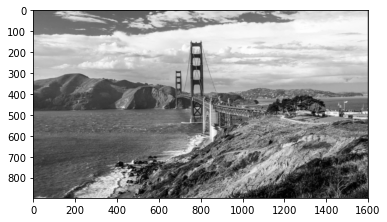

(897, 1601)

In [4]:
sf_blurred = blur(sf)

plt.imsave('sf_blurred.bmp', sf_blurred, cmap='gray')

plt.imshow(sf_blurred, cmap='gray')
plt.show()

sf_blurred.shape

## Sample

In [5]:
def sample(image):
    
    (height, width) = image.shape
    
    height_reduced = height // 2 + height % 2
    width_reduced = width // 2 + width % 2
    image_reduced = np.zeros((height_reduced, width_reduced))
    
    for h in range(height_reduced):
            
            for w in range(width_reduced):
                    
                    image_reduced[h,w] = image[h*2,w*2]
                    
    return image_reduced
                    

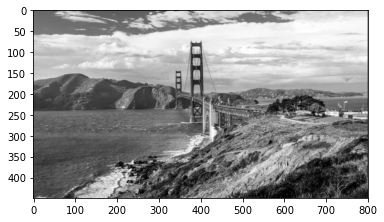

(449, 801)

In [6]:
sf_sampled = sample(sf_blurred)

plt.imsave('sf_sampled.bmp', sf_sampled, cmap='gray')

plt.imshow(sf_sampled, cmap='gray')
plt.show()

sf_sampled.shape

## Interpolate

In [7]:
def interpolate(image):

    (height, width) = image.shape

    height_expanded = height * 2 - 1
    width_expanded = width * 2 - 1

    image_v_span = np.zeros((height_expanded, width))
    image_expanded = np.zeros((height_expanded, width_expanded))

    for h in range(height):

        for w in range(width):

            # Copy even rows from original
            image_v_span[h*2, w] = image[h, w]

            # Interpolate odd rows
            if h != height - 1:
                image_v_span[h*2+1, w] = np.mean([image[h, w], image[h+1, w]])


    for h in range(height_expanded):

        for w in range(width):

            # Copy even columns from original
            image_expanded[h, w*2] = image_v_span[h, w]

            # Interpolate odd columns
            if w != width - 1:
                image_expanded[h, w*2+1] = np.mean([image_v_span[h, w], image_v_span[h, w+1]])

    return image_expanded

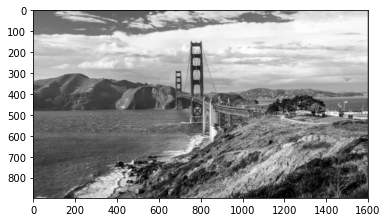

(897, 1601)

In [8]:
sf_interpolated = interpolate(sf_sampled)

plt.imsave('sf_interpolated.bmp', sf_interpolated, cmap='gray')

plt.imshow(sf_interpolated, cmap='gray')
plt.show()

sf_interpolated.shape

## Construct Pyramid

In [9]:
def compress(image):
    
    blurred = blur(image)
    sampled = sample(blurred)
    estimate = interpolate(sampled)
    
    error = image - estimate
    
    return sampled, estimate, error

In [10]:
def pyramid_contruct(image, level=3):
    
    pyramid, laplacian = [], []
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    pyramid.append(image)
    ax1.imshow(image, cmap='gray')
    ax1.set_title(f'Pyramid {level}')
    
    if level == 0:
        
        laplacian.append(image)
        ax1.imshow(image, cmap='gray')
        ax1.set_title(f'Pyramid {level}')
        ax2.imshow(np.zeros_like(image), cmap='gray')
        ax3.imshow(image, cmap='gray')
        plt.show()
        
    else:
        
        sampled, estimate, error = compress(image)
        
        # Plot
        ax2.imshow(estimate, cmap='gray')
        ax2.set_title(f'Estimate from Pyramid {level-1}')
                
        ax3.imshow(error, cmap='gray')
        ax3.set_title(f'Laplacian')
        
        plt.show()
        
        # Append
        laplacian.append(error)
        
        depth = level - 1
        pyramid_prev, laplacian_prev = pyramid_contruct(sampled, depth)
        
        for p in pyramid_prev:
            pyramid.append(p)
        for l in laplacian_prev:
            laplacian.append(l)
            
    return pyramid, laplacian

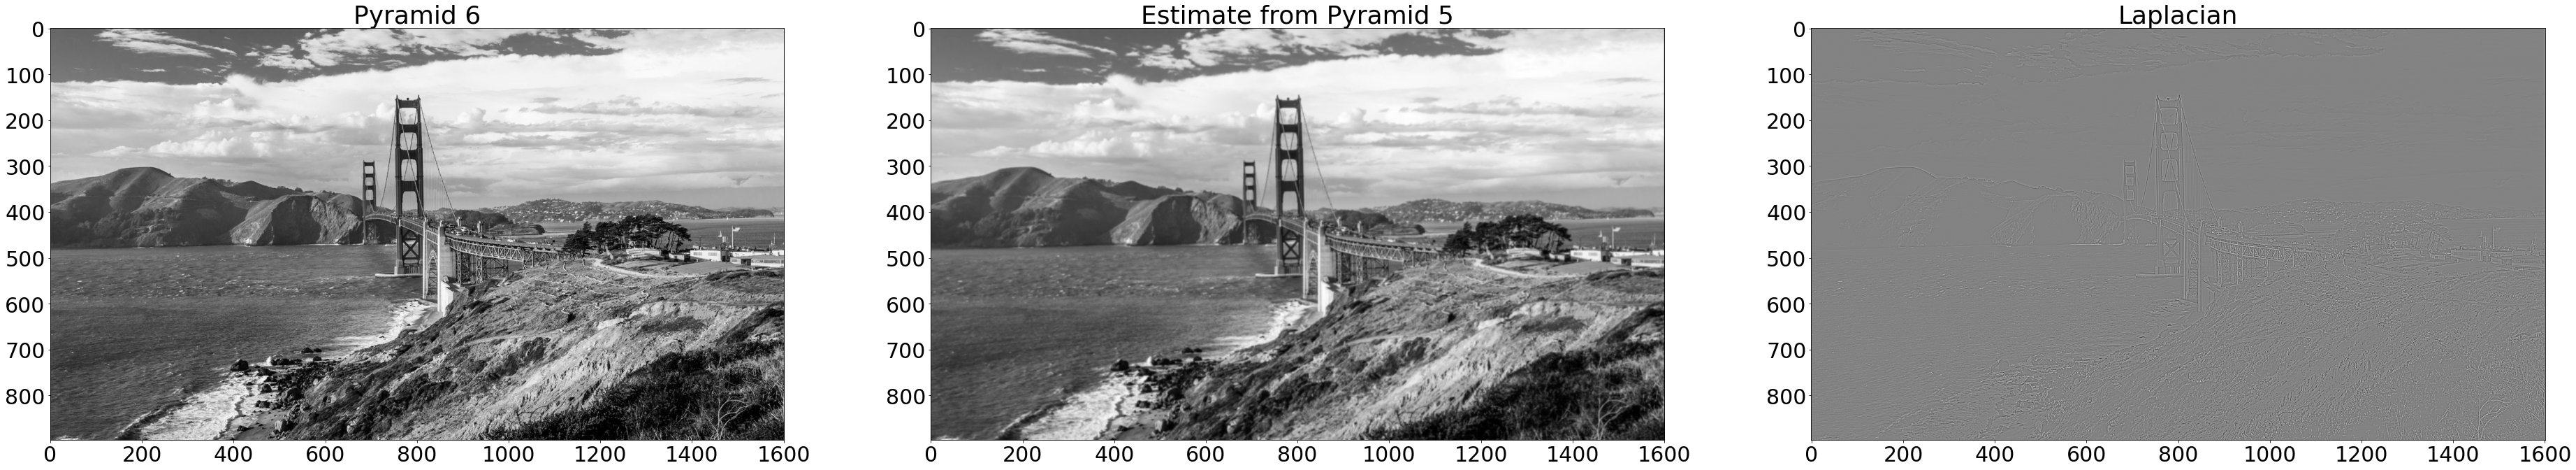

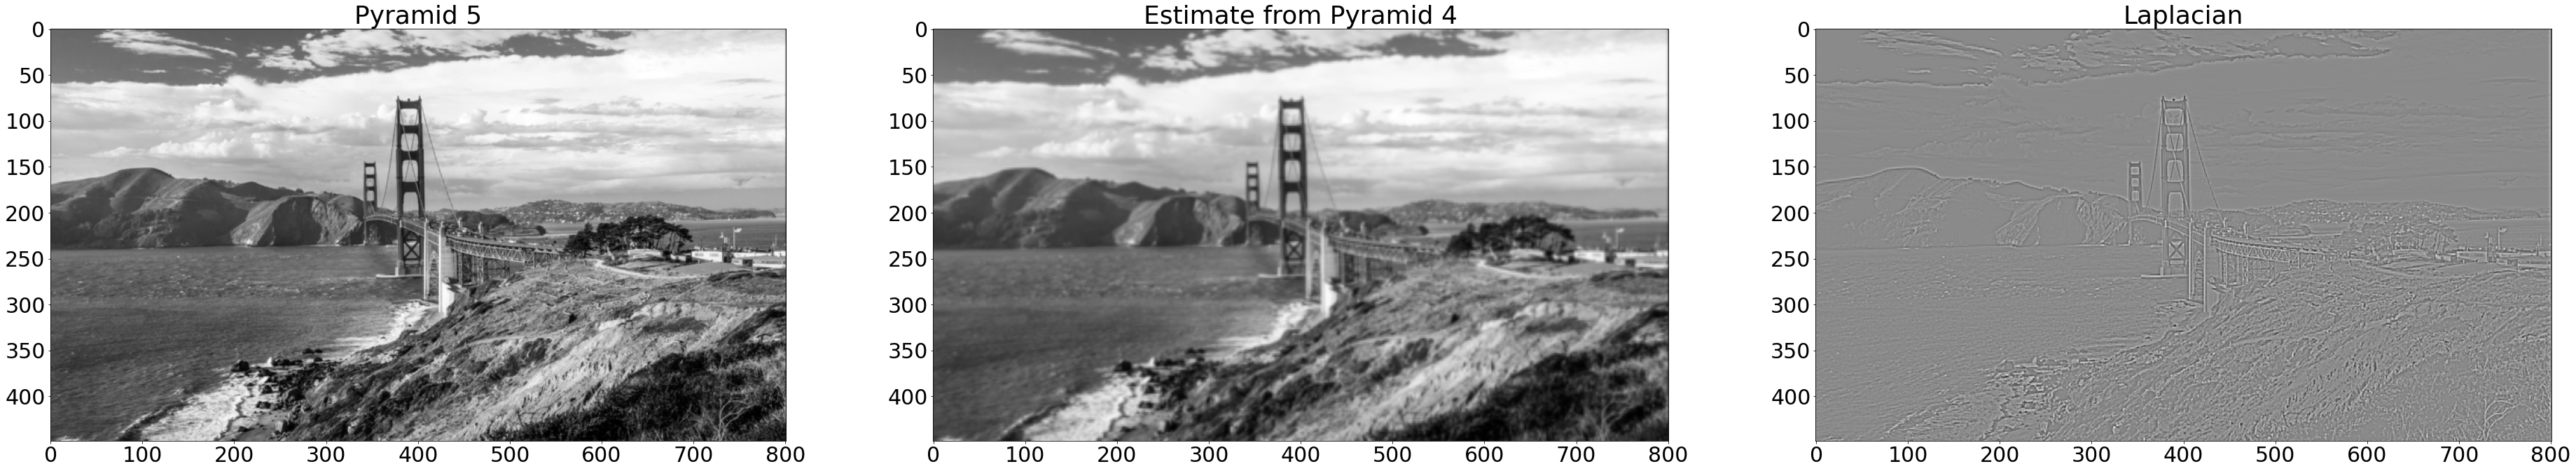

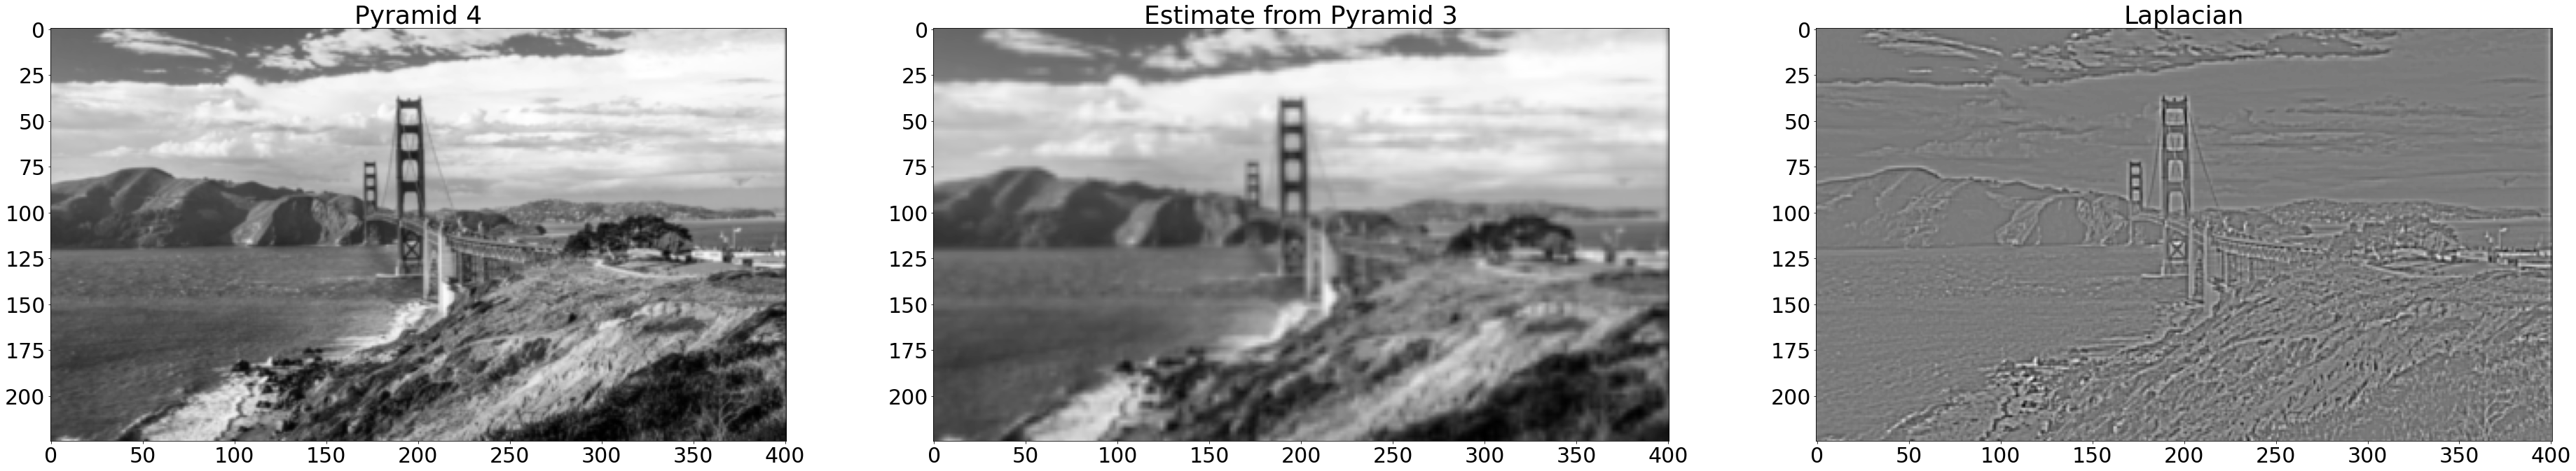

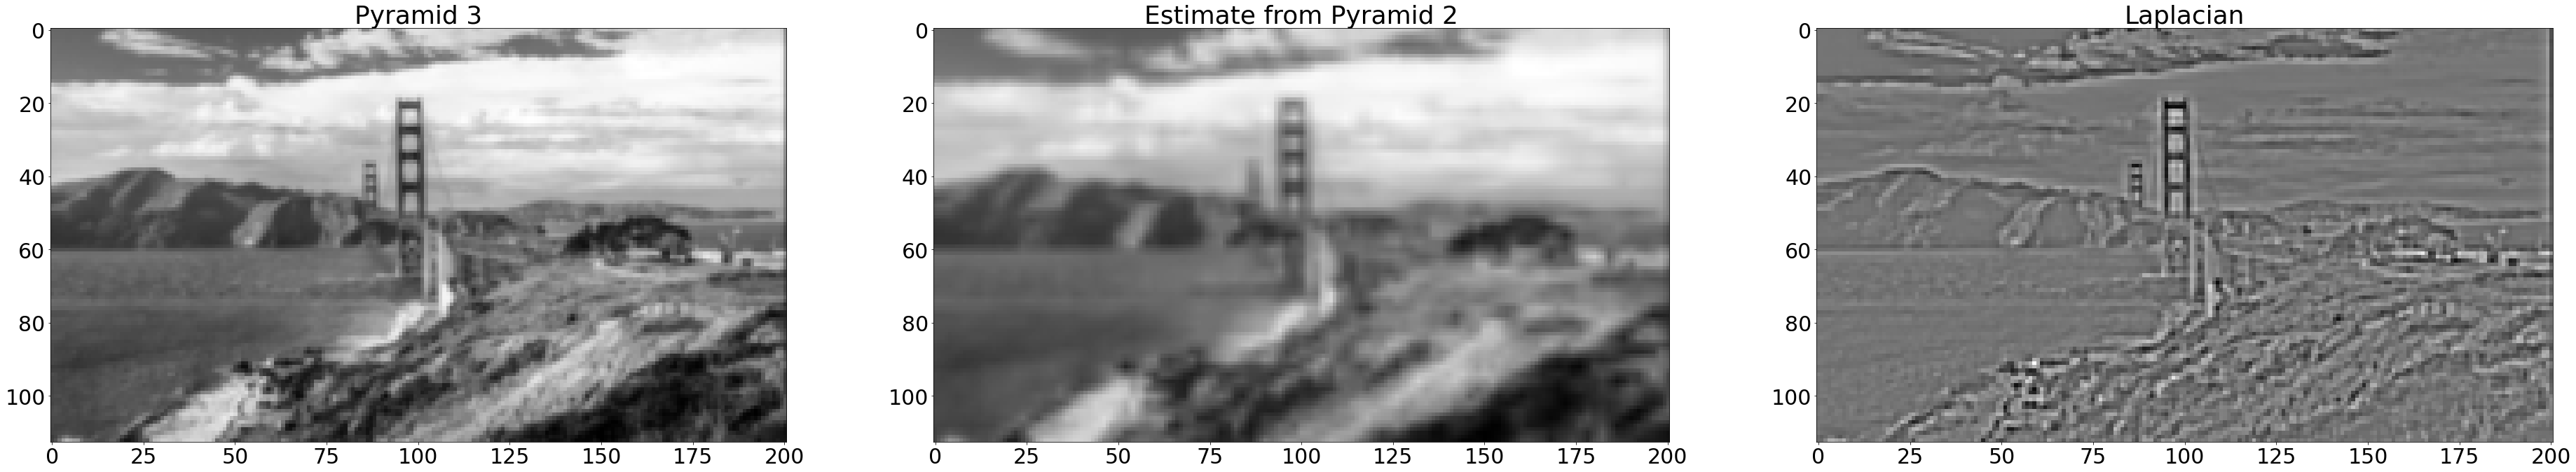

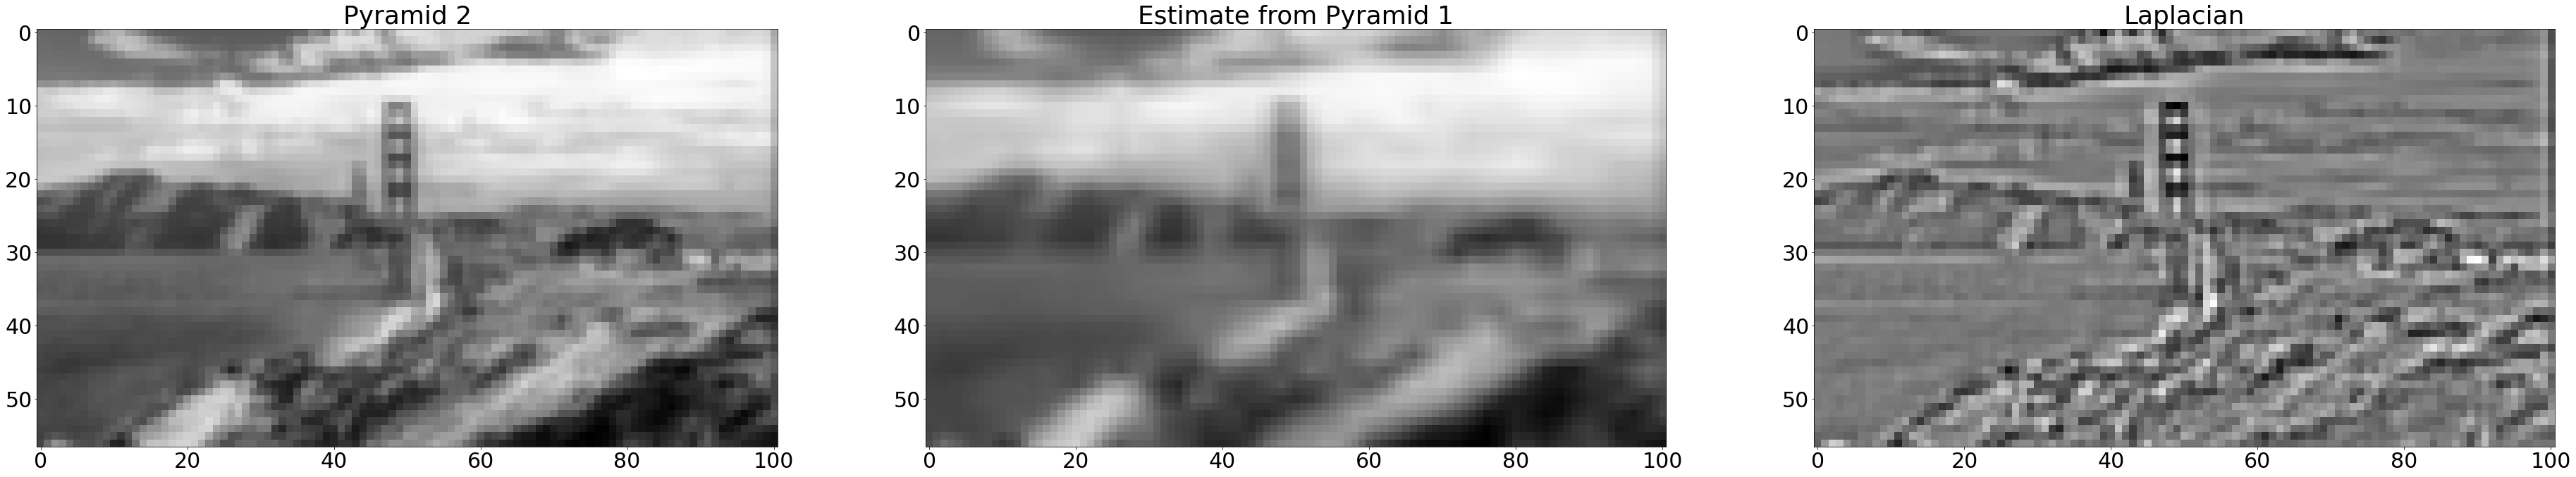

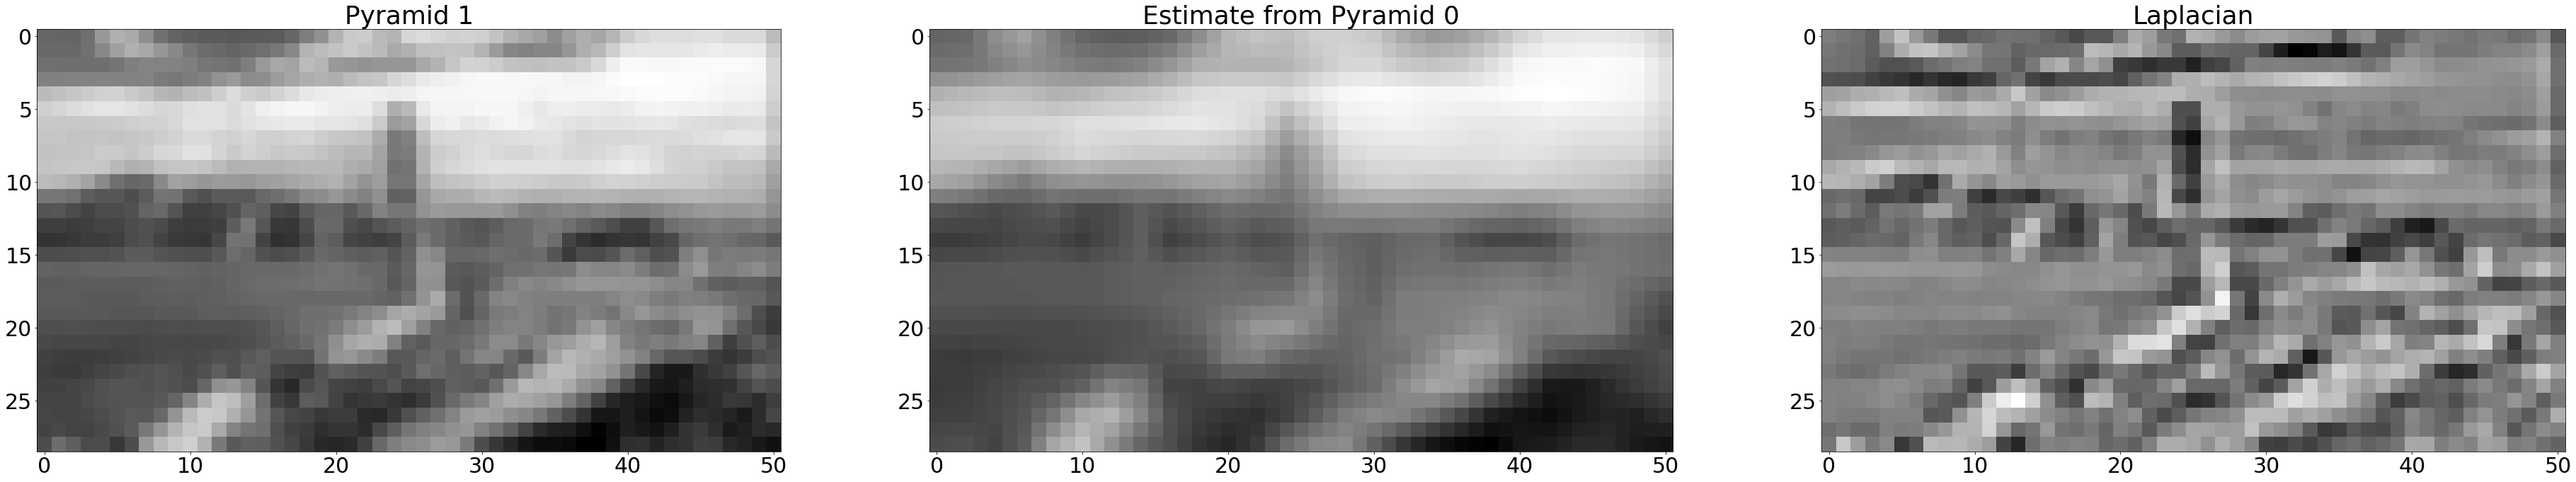

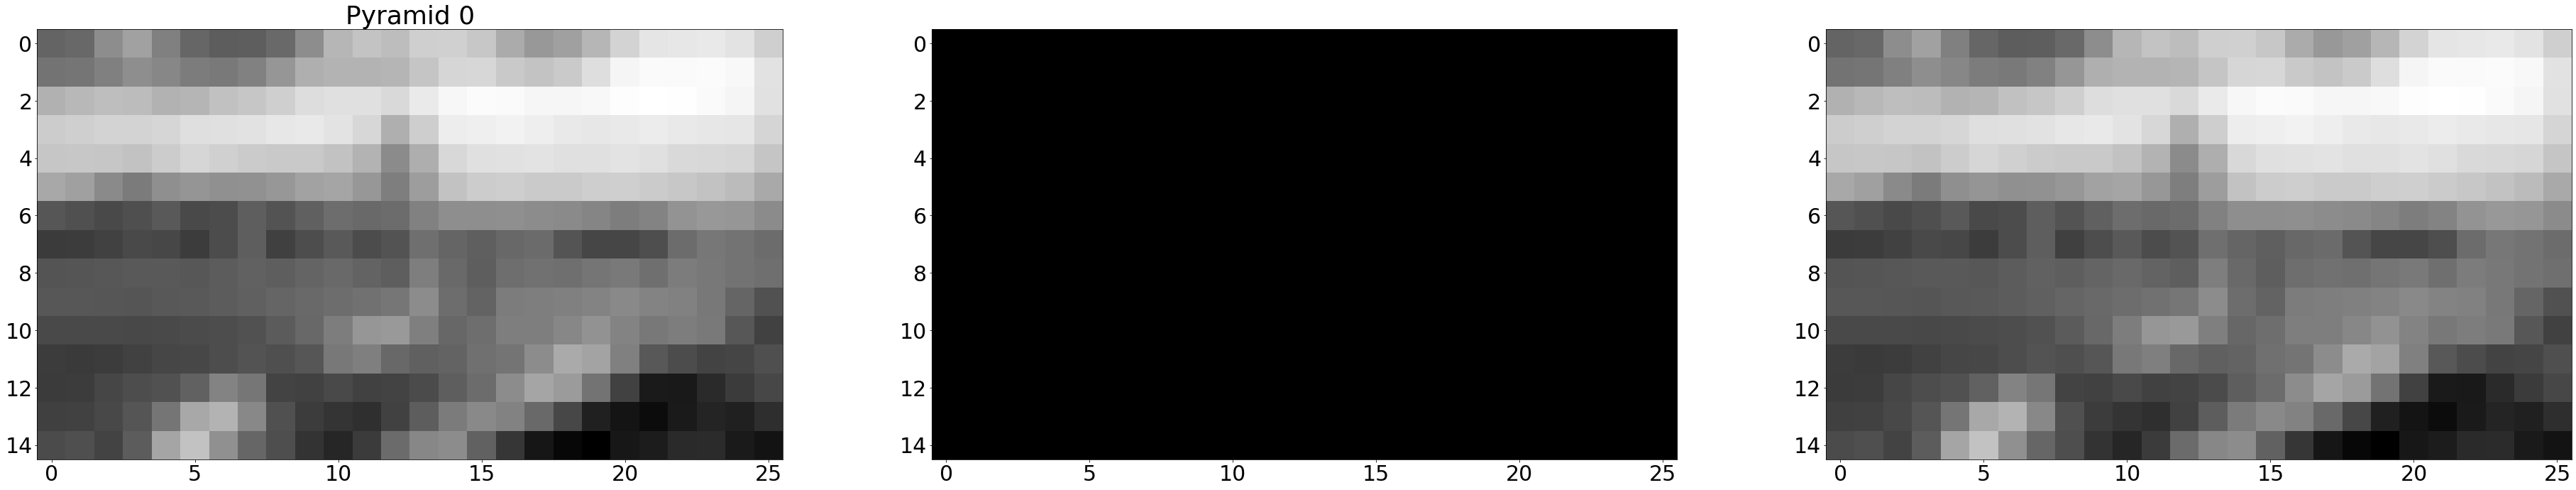

In [11]:
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (48, 12)

pyramid, laplacian = pyramid_contruct(sf, level=6)

In [12]:
print('Pyramid')
for p in pyramid:
    print(p.shape)

print()

print('Laplacian')
for l in laplacian:
    print(l.shape)

Pyramid
(897, 1601)
(449, 801)
(225, 401)
(113, 201)
(57, 101)
(29, 51)
(15, 26)

Laplacian
(897, 1601)
(449, 801)
(225, 401)
(113, 201)
(57, 101)
(29, 51)
(15, 26)


## Recover

In [13]:
def decompress(laplacian):
    
    recovered = None
    
    if len(laplacian) == 1:
        
        recovered = laplacian.pop(0)
        
    else:
        
        error = laplacian.pop(0)
        
        decompressed = decompress(laplacian)
        
        interpolated = interpolate(decompressed)
    
        recovered = error + interpolated
    
    clear_output(wait=True)
    plt.imshow(recovered, cmap='gray')
    plt.show()
    
    # Just to mimic some network latency...
    # time.sleep(6 - len(laplacian))
    
    return recovered

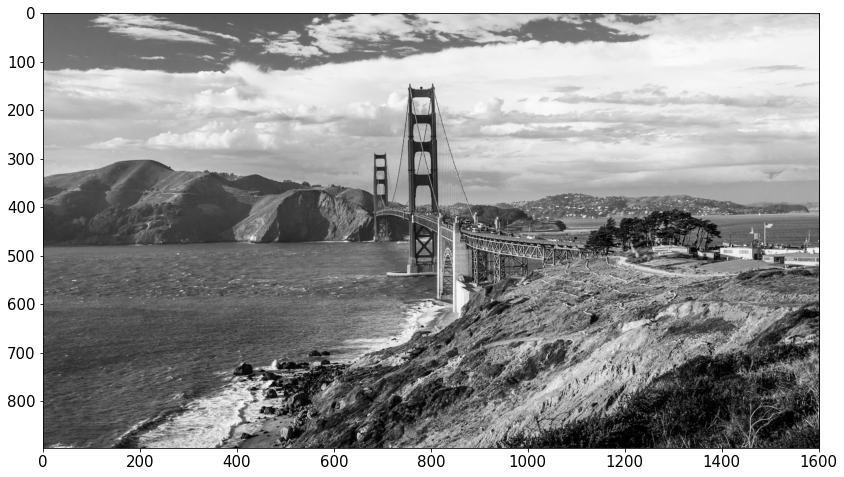

In [21]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = (32, 8)

lap = [l for l in laplacian]

recovered = decompress(lap)

# Problem 2

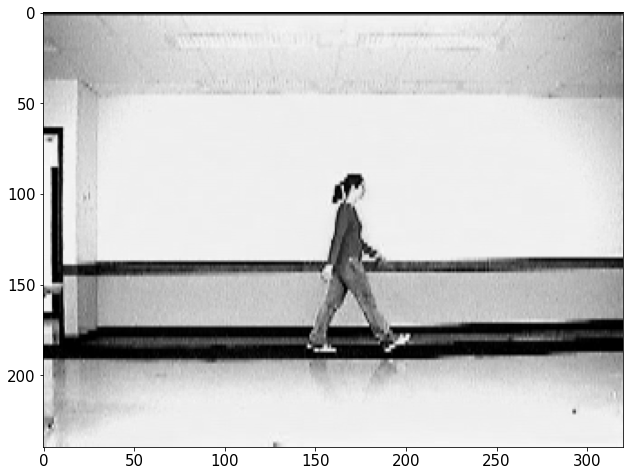

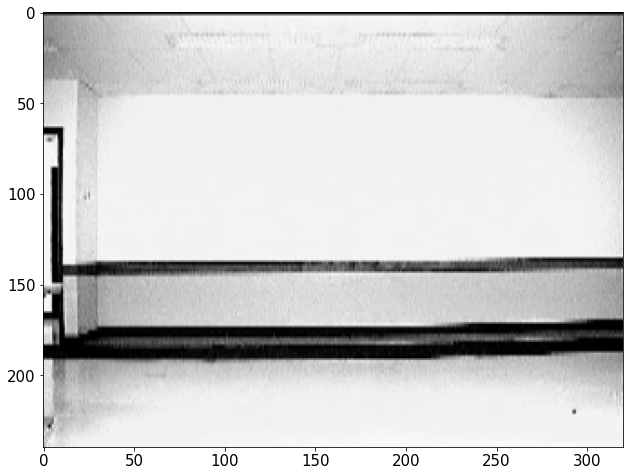

In [68]:
folder = './input'

walk_filepath = os.path.join(folder, 'walk.bmp')
background_filepath = os.path.join(folder, 'bg000.bmp')

walk = imread(walk_filepath)
background = imread(background_filepath)

plt.imshow(walk, cmap='gray')
plt.show()
plt.imshow(background, cmap='gray')
plt.show()

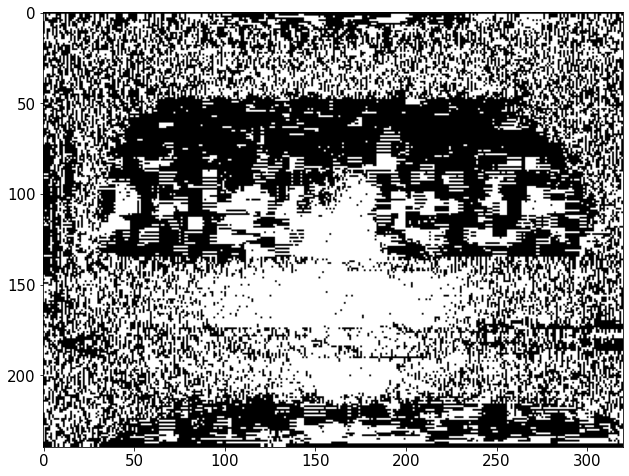

In [61]:
threshold = 25

region =  np.array(np.greater(np.absolute(walk - background), threshold), dtype=float)

plt.imshow(region, cmap='gray')
plt.show()

# Problem 3

In [64]:
files = os.listdir(folder)

files.remove('walk.bmp')

walk_filepath = os.path.join(folder, 'walk.bmp')
background_filepath = [os.path.join(folder, file) for file in files]

walk = imread(walk_filepath)
background = np.array([imread(image) for image in background_filepath])

In [65]:
print(walk.shape, background.shape)

(240, 320) (30, 240, 320)


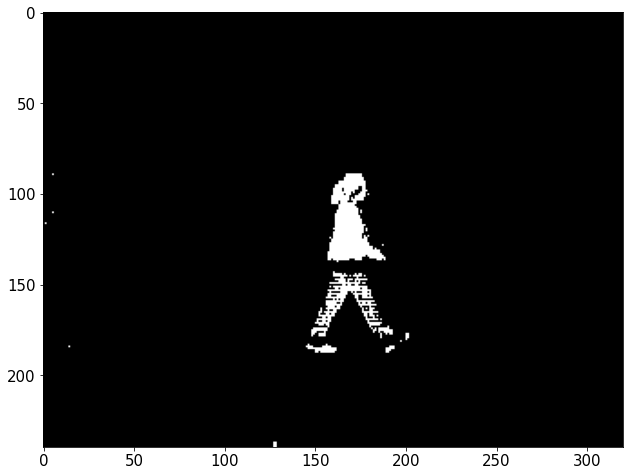

In [66]:
mean_intensity = np.mean(background, axis=0)
var_intensity = np.var(background, axis=0)

mahalanobis_dist = (walk - mean_intensity)**2 / (var_intensity+1E-5)

region =  np.array(np.greater(mahalanobis_dist, threshold**2), dtype=float)

plt.imshow(region, cmap='gray')
plt.show()

# Problem 4

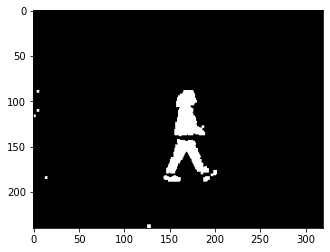

In [72]:
kernel = np.ones((3,3), np.uint8) 
d_bsIm = cv2.dilate(region, kernel, iterations=1) 

plt.imshow(d_bsIm, cmap='gray')
plt.show()

In [94]:
L, num = label(d_bsIm, return_num=True, connectivity=1)
row_list = [dict(Counter(L[i])) for i in range(L.shape[0])]

region_size = {}

for i in range(num+1): 
    region_size[i] = 0

for row_dict in row_list:
    for k, v in row_dict.items():
        region_size[k] += v

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}


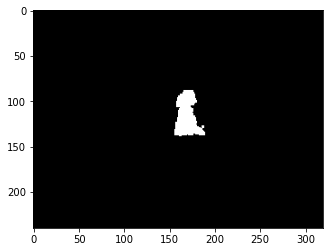

In [109]:
region_size = {k: v for k, v in sorted(region_size.items(), key=lambda item: item[1], reverse=True)}

largest_region_lable = list(region_size.keys())[1]

largest_region =  np.array(np.equal(L, largest_region_lable), dtype=float)

plt.imshow(largest_region, cmap='gray')
plt.show()